In [57]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

import gymnasium as gym 

from einops.layers.torch import Rearrange, Reduce
from einops import rearrange, reduce, repeat, pack, unpack

import numpy as np
import matplotlib.pyplot as plt

In [55]:
env = gym.make("FetchReach-v3", render_mode='rgb_array')
# env = gym.make('FrankaKitchen-v1', tasks_to_complete=['microwave', 'kettle', 'bottom_left_burner'], render_mode='rgb_array')
# env = gym.make('AntMaze_HardestMaze_DGR-v3', render_mode='rgb_array')
# env = gym.make('PointMaze_Medium-v3', render_mode='rgb_array')
# env = gym.make('HandManipulateBlockFull-v1', render_mode='rgb_array')
env.reset()

({'observation': array([ 1.34185486e+00,  7.49100508e-01,  5.34707205e-01,  2.00232294e-04,
          6.92377335e-05, -3.25336729e-06, -2.19655130e-09,  5.16581247e-06,
          4.76882452e-06, -2.31810359e-06]),
  'achieved_goal': array([1.34185486, 0.74910051, 0.5347072 ]),
  'desired_goal': array([1.38707208, 0.72719278, 0.5201527 ])},
 {})

In [78]:
granularity = 3
mesh = np.meshgrid(*[np.linspace(lo, hi, granularity) for lo, hi in zip(env.action_space.low, env.action_space.high)])
base_actions = np.array([a.flat[:] for a in mesh]).T

In [89]:
mesh[0].flat[:]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

In [56]:
env.action_space

Box(-1.0, 1.0, (4,), float32)

In [54]:
for i in range(100):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
obs, truncated

({'observation': array([ 1.31326269e+00,  2.00373954e-01,  4.89533634e-01,  0.00000000e+00,
          0.00000000e+00,  1.56357801e-02,  2.45778242e-02, -2.38718166e-02,
          3.37862063e-04,  1.03624589e-03]),
  'achieved_goal': array([1.31326269, 0.20037395, 0.48953363]),
  'desired_goal': array([1.42130382, 0.88312153, 0.41733993])},
 True)

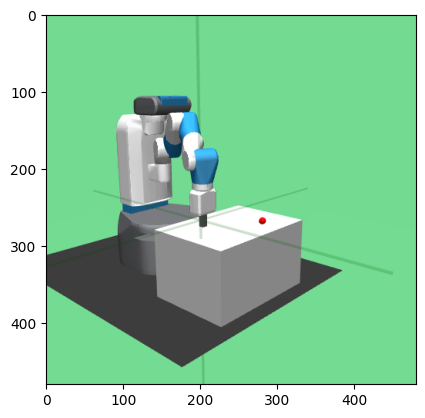

In [47]:
plt.imshow(env.render())

In [21]:
obs, reward, terminated, truncated, info

({'observation': array([ 1.35959726e+00,  7.24660133e-01,  5.60535845e-01,  0.00000000e+00,
          0.00000000e+00,  1.52405623e-02, -2.07587146e-02,  2.23048539e-02,
          5.00715241e-04,  3.65832760e-04]),
  'achieved_goal': array([1.35959726, 0.72466013, 0.56053584]),
  'desired_goal': array([1.38895852, 0.62002386, 0.46562389])},
 -1.0,
 False,
 False,
 {'is_success': 0.0})

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from einops.layers.torch import Rearrange


def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

class ConvNet(nn.Module):
    def __init__(self, in_channels, d_size, p=0.3):
        super().__init__()
        self.p=p
        self.cnn = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=32, kernel_size=3, padding='same'),
                    nn.MaxPool2d(2),
                    nn.ReLU(),
                    nn.Conv2d(32, out_channels=64, kernel_size=3, padding='same'),
                    nn.MaxPool2d(2),
                    nn.ReLU(),
                    nn.Conv2d(64, out_channels=64, kernel_size=3, padding='same'),
                    nn.MaxPool2d(4),
                    nn.ReLU(),
        )
        self.dense = nn.Sequential(
                        Rearrange('b c h w -> b (c h w)'),
                        nn.Linear(2304, 128),
                        nn.ReLU(),
                        nn.Linear(128, d_size),
                        nn.ReLU(),
        )

    def forward(self, X):
        return self.dense(self.cnn(X))

class DeConvNet(nn.Module):
    def __init__(self, out_channels, in_size):
        super().__init__()
        self.deconv = nn.Sequential(
                        nn.Linear(in_size, 64),
                        Rearrange('b (h w) -> b () h w', h=8, w=8),
                        nn.ConvTranspose2d(1, 32, kernel_size=4, stride=2, dilation=2),
                        nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2,dilation=2),
                        nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2),
        )
    
    def forward(self, X):
        return self.deconv(X)       

class AE(nn.Module):
    def __init__(self, in_channels, d_size, p=0.3):
        super().__init__()
        self.encoder = ConvNet(in_channels, d_size, p=p)
        self.decoder = DeConvNet(in_channels, d_size)
        self.apply(init_weights)
    
    def forward(self, X):
        return self.decoder(self.encoder(X))

In [3]:
d_size = 128
net = ConvNet(3, d_size)
deconv = DeConvNet(3, d_size)
autoencoder = AE(3, d_size)
net.apply(init_weights)
X = torch.rand(7,3,96,96)
net(X).shape, deconv(net(X)).shape, autoencoder(X).shape

(torch.Size([7, 128]), torch.Size([7, 3, 96, 96]), torch.Size([7, 3, 96, 96]))

In [12]:
import numpy as np

In [13]:
ims = np.load('test_images.npy')
ims.shape

(6, 96, 96, 3)

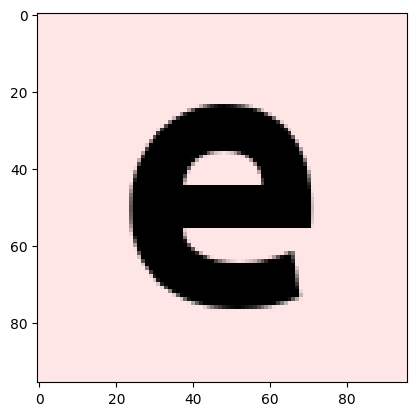

In [17]:
plt.imshow(ims[0])

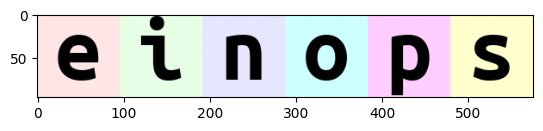

In [23]:
plt.imshow(rearrange(ims, 'b h w c -> h (b w) c'))

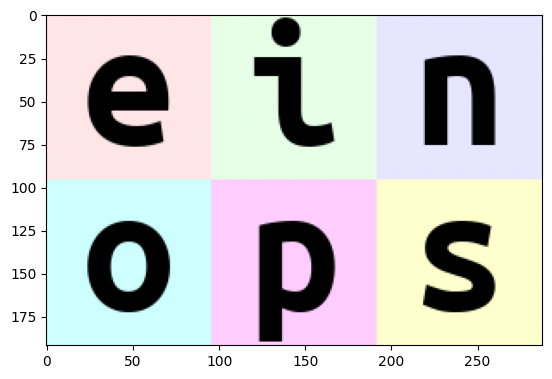

In [30]:
plt.imshow(rearrange(ims, '(b1 b2) h w c -> (b1 h) (b2 w) c', b1=2))

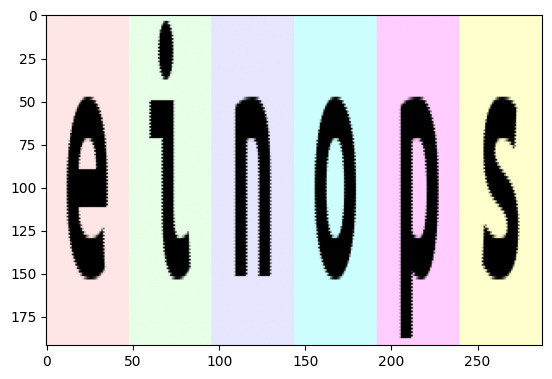

In [36]:
plt.imshow(rearrange(ims, 'b h (w w2) c -> (h w2) (b w) c', w2=2))

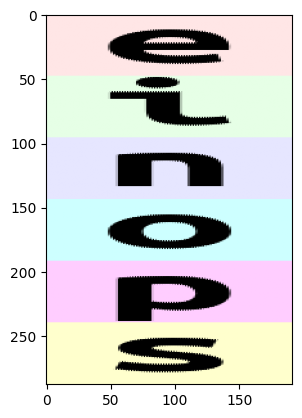

In [43]:
plt.imshow(rearrange(ims, 'b (h h2) w c -> (b h) (w h2) c', h2=2))

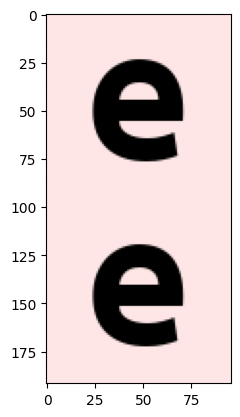

In [133]:
plt.imshow(repeat(ims[0], 'h w c -> (2 h) w c'))

In [99]:
im2 = reduce(ims, 'b h w c -> b () () c', 'max') - ims
# im2 /= reduce(im2, 'b h w c -> b () () c', 'max')
# plt.imshow(rearrange(im2, 'b h w c -> h (b w) c'))

(<matplotlib.image.AxesImage at 0x17945515490>,
 array([[[1.        , 0.90196078, 0.90196078]]]))

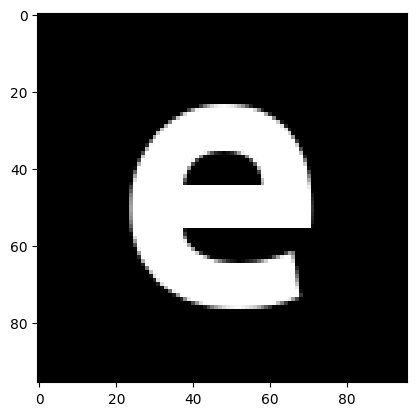

In [130]:
plt.imshow(im2[0]/reduce(im2, 'b h w c -> b () () c', 'max')[0]),reduce(im2, 'b h w c -> b () () c', 'max')[0]

In [139]:
reduce(ims, 'b h w c -> b c () ()', 'mean')[0]

array([[[0.82030356]],

       [[0.73987779]],

       [[0.73987779]]])

In [144]:
x = torch.rand(7, 12, 16*3)
q, k, v = tuple(rearrange(x, 'b t (k d) -> k b t d ', k=3))

In [146]:
(q == x[:,:,:16]).all()

tensor(True)

In [151]:
def check_sizes(image_size, patch_size):
    sqrt_num_patches, remainder = divmod(image_size, patch_size)
    assert remainder == 0, "`image_size` must be divisibe by `patch_size`"
    num_patches = sqrt_num_patches ** 2
    return num_patches

class Patcher(nn.Module):
    def __init__(
        self,
        image_size=256,
        patch_size=16,
        in_channels=3,
        num_features=128,
    ):
        num_patches = check_sizes(image_size, patch_size)
        super().__init__()
        # per-patch fully-connected is equivalent to strided conv2d
        self.patcher = nn.Conv2d(
            in_channels, num_features, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        patches = self.patcher(x)
        batch_size, num_features, _, _ = patches.shape
        patches = patches.permute(0, 2, 3, 1)
        print(patches.shape)
        patches = patches.view(batch_size, -1, num_features)
        
        return patches


In [152]:
p = Patcher()

In [153]:
p(torch.rand(7,3,256,256)).shape

torch.Size([7, 16, 16, 128])


torch.Size([7, 256, 128])

In [154]:
batch, height, width, c = 6, 16, 16, 256
patch_tokens = np.random.random([batch, height, width, c])
class_tokens = np.zeros([batch, c])

In [157]:
input_packed, ps = pack([class_tokens, patch_tokens], 'b * c')
input_packed.shape, ps

((6, 257, 256), [(), (16, 16)])

In [182]:
a, b,c = unpack(input_packed, [(),(), (255,)], 'b * c')
a.shape, b.shape, c.shape

((6, 256), (6, 256), (6, 255, 256))